# HVAC optimization case study
## Modeling

### Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from helpers import *

In [3]:
root_path = Path.cwd().parent
processed_data_path = root_path.joinpath("data/processed")
model_path = root_path.joinpath("models")
figure_path = root_path.joinpath("references/figures")
mlflow_path = f"file:{root_path.joinpath('experiments')}"

In [4]:
RANDOM_STATE = 1337
N_JOBS = -1

### Load data

In [5]:
train_df = pd.read_csv(processed_data_path.joinpath("train_processed.csv"))
train_df.name = "train"
test_df = pd.read_csv(processed_data_path.joinpath("test_processed.csv"))
test_df.name = "test"
dataframes = [train_df, test_df]

In [6]:
train_df.head()

,temperature,humidity,light,co2,humidityratio,occupancy,year,month,day,weekday,hour,minute,week,weekend,office_hour,lunch_break,night,high_co2,light_on
0,23.18,27.2720,426.0,721.25,0.004793,1,2015,2,4,2,17,51,6,False,False,False,False,False,True
1,23.15,27.2675,429.5,714.00,0.004783,1,2015,2,4,2,17,52,6,False,False,False,False,False,True
2,23.15,27.2450,426.0,713.50,0.004779,1,2015,2,4,2,17,53,6,False,False,False,False,False,True
3,23.15,27.2000,426.0,708.25,0.004772,1,2015,2,4,2,17,54,6,False,False,False,False,False,True
4,23.10,27.2000,426.0,704.50,0.004757,1,2015,2,4,2,17,55,6,False,False,False,False,False,True


In [7]:
test_df.tail()

,temperature,humidity,light,co2,humidityratio,occupancy,year,month,day,weekday,hour,minute,week,weekend,office_hour,lunch_break,night,high_co2,light_on
2660,24.290000,25.700000,808.0,1150.25,0.004829,1,2015,2,4,2,10,39,6,False,True,False,False,True,True
2661,24.330000,25.736000,809.8,1129.20,0.004848,1,2015,2,4,2,10,40,6,False,True,False,False,True,True
2662,24.330000,25.700000,817.0,1125.80,0.004841,1,2015,2,4,2,10,41,6,False,True,False,False,True,True
2663,24.356667,25.700000,813.0,1123.00,0.004849,1,2015,2,4,2,10,42,6,False,True,False,False,True,True
2664,24.408333,25.681667,798.0,1124.00,0.004860,1,2015,2,4,2,10,43,6,False,True,False,False,True,True


### Preprocessing

In [8]:
target = "occupancy"
date_features = ["year", "month", "day", "weekday", "hour", "minute", "week", "weekend"]
org_features = ["temperature", "humidity", "light", "humidityratio"] 
all_features = [col for col in train_df.columns if col != target]
bool_features = [feat for feat in train_df[all_features] if train_df[feat].dtype == "bool"]

In [9]:
X_train = train_df.drop(columns=target)
y_train = train_df[target]
X_test = test_df.drop(columns=target)
y_test = test_df[target]

In [10]:
print("All features:", all_features, 
      "Date features:", date_features,
      "Original features:", org_features, 
      "Boolean features:", bool_features, 
      sep="\n")

All features:
['temperature', 'humidity', 'light', 'co2', 'humidityratio', 'year', 'month', 'day', 'weekday', 'hour', 'minute', 'week', 'weekend', 'office_hour', 'lunch_break', 'night', 'high_co2', 'light_on']
Date features:
['year', 'month', 'day', 'weekday', 'hour', 'minute', 'week', 'weekend']
Original features:
['temperature', 'humidity', 'light', 'humidityratio']
Boolean features:
['weekend', 'office_hour', 'lunch_break', 'night', 'high_co2', 'light_on']


### Create ML Pipeline
>Rule #4: Keep the first model simple and get the infrastructure right.

In [11]:
MLPipe = MLPipeline(X_train, y_train, X_test, y_test, model_path, figure_path, mlflow_path, "hvac_optimization")

#### Baseline model

In [12]:
baseline_params = {"strategy": "stratified", "random_state": RANDOM_STATE}

In [13]:
baseline_pipe = Pipeline(steps=[
    ("model", DummyClassifier(**baseline_params))])

Running pipeline for 'baseline' model
Accuracy train: 0.6656
CV accuracy train: 0.6565
Accuracy test: 0.5801
F1-score train: 0.2178
CV F1-score train: 0.196
F1-score test: 0.2691
Classification report
              precision    recall  f1-score   support

           0       0.64      0.79      0.71      1693
           1       0.37      0.21      0.27       972

    accuracy                           0.58      2665
   macro avg       0.50      0.50      0.49      2665
weighted avg       0.54      0.58      0.55      2665



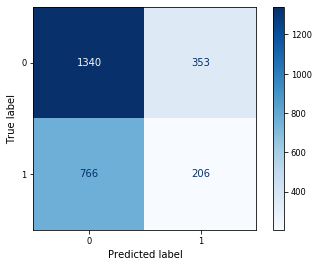

In [14]:
baseline = MLPipe.run_pipeline(baseline_pipe, org_features, "baseline", save_model=False)

### Decision tree model

In [15]:
tree_params = {"random_state": RANDOM_STATE}

In [16]:
tree_pipe = Pipeline(steps=[
    ("scale", StandardScaler()), 
    ("model", DecisionTreeClassifier(**tree_params))])

Running pipeline for 'tree' model
Accuracy train: 0.9998
CV accuracy train: 0.9274
Accuracy test: 0.9598
F1-score train: 0.9994
CV F1-score train: 0.8195
F1-score test: 0.945
Classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1693
           1       0.94      0.95      0.95       972

    accuracy                           0.96      2665
   macro avg       0.96      0.96      0.96      2665
weighted avg       0.96      0.96      0.96      2665



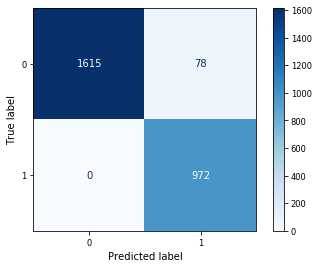

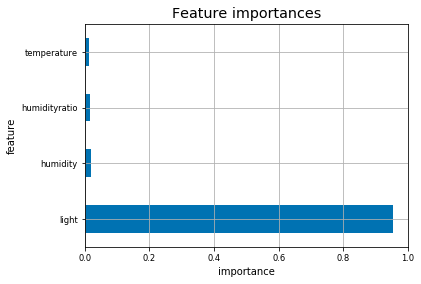

In [17]:
tree_model = MLPipe.run_pipeline(tree_pipe, org_features, "tree", save_model=False)

### DT model with limited depth

In [18]:
tree_params_limited = {"max_depth": 3, "random_state": RANDOM_STATE}

In [19]:
tree_pipe_limited = Pipeline(steps=[
    ("scale", StandardScaler()), 
    ("model", DecisionTreeClassifier(**tree_params_limited))])

Running pipeline for 'tree_limited' model
Accuracy train: 0.9888
CV accuracy train: 0.9611
Accuracy test: 0.9786
F1-score train: 0.9742
CV F1-score train: 0.9101
F1-score test: 0.9714
Classification report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1693
           1       0.95      1.00      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665



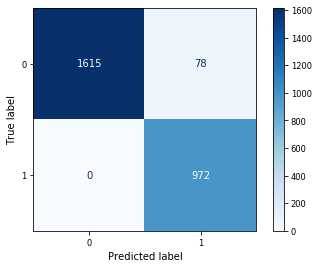

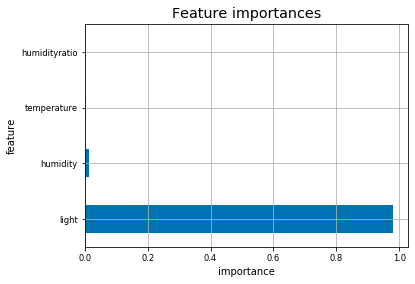

In [20]:
tree_model_limited = MLPipe.run_pipeline(tree_pipe_limited, org_features, "tree_limited", save_model=False)

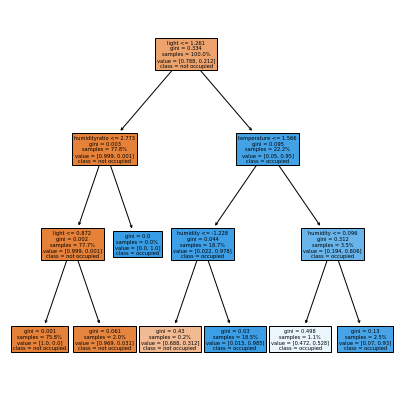

In [21]:
plt.figure(figsize=(7, 7))
plot_tree(decision_tree=tree_model_limited["model"].named_steps["model"],
                      feature_names=org_features,
                      class_names=["not occupied", "occupied"],
                      filled=True,
                      proportion=True)

plt.savefig(figure_path.joinpath("tree_plot.svg"), format="svg")

### DT model with limited depth and handpicked features

In [22]:
tree_params_handpicked = tree_params_limited

In [23]:
tree_handpicked_pipe = tree_pipe_limited

In [24]:
handpicked_features = ["light_on", "weekend"]

Running pipeline for 'tree_handpicked' model
Accuracy train: 0.9856
CV accuracy train: 0.9856
Accuracy test: 0.9707
F1-score train: 0.9673
CV F1-score train: 0.9687
F1-score test: 0.9614
Classification report
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1693
           1       0.93      1.00      0.96       972

    accuracy                           0.97      2665
   macro avg       0.96      0.98      0.97      2665
weighted avg       0.97      0.97      0.97      2665



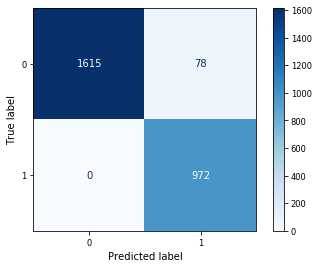

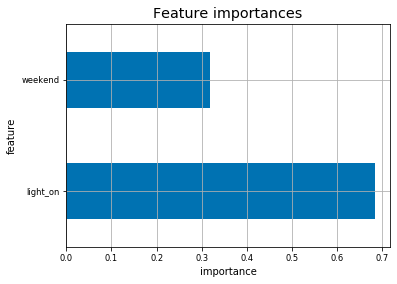

In [25]:
tree_handpicked_model = MLPipe.run_pipeline(tree_handpicked_pipe, handpicked_features, "tree_handpicked", save_model=False)

### RandomForrest (RF) model

In [26]:
rf_params = {"random_state": RANDOM_STATE, "n_jobs": N_JOBS}

In [27]:
rf_pipe = Pipeline(steps=[
    ("scale", StandardScaler()), 
    ("model", RandomForestClassifier(**rf_params))])

Running pipeline for 'rf' model
Accuracy train: 0.9998
CV accuracy train: 0.9454
Accuracy test: 0.9448
F1-score train: 0.9994
CV F1-score train: 0.8583
F1-score test: 0.9226
Classification report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1693
           1       0.94      0.90      0.92       972

    accuracy                           0.94      2665
   macro avg       0.94      0.94      0.94      2665
weighted avg       0.94      0.94      0.94      2665



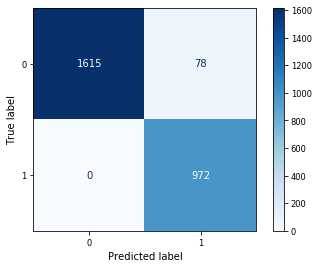

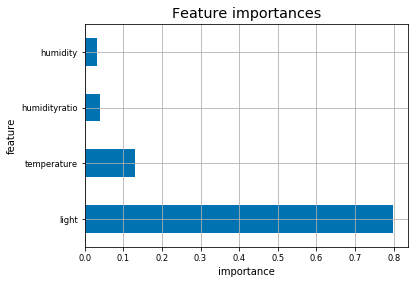

In [28]:
rf_model = MLPipe.run_pipeline(rf_pipe, org_features, "rf", save_model=False)

### Minimal RF model

In [29]:
minimal_pipe = rf_pipe

In [30]:
minimal_features = ["light"]

Running pipeline for 'rf_minimal' model
Accuracy train: 0.992
CV accuracy train: 0.9661
Accuracy test: 0.9568
F1-score train: 0.9815
CV F1-score train: 0.9243
F1-score test: 0.9404
Classification report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1693
           1       0.95      0.93      0.94       972

    accuracy                           0.96      2665
   macro avg       0.95      0.95      0.95      2665
weighted avg       0.96      0.96      0.96      2665



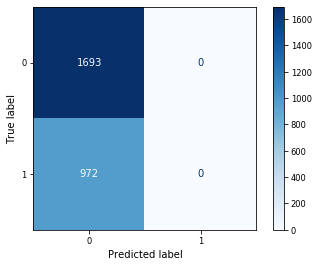

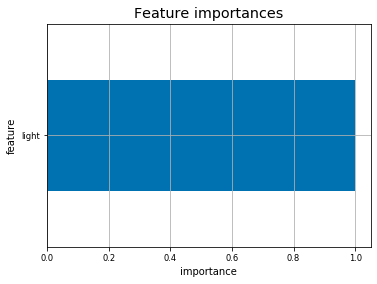

In [31]:
minimal = MLPipe.run_pipeline(minimal_pipe, minimal_features, "rf_minimal", save_model=False)

### RF model with handpicked features

In [32]:
handpicked_pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("encode", OneHotEncoder(categories="auto")),
    ("model", RandomForestClassifier(**rf_params))])

In [33]:
handpicked_features = ["light_on", "weekend", "office_hour"]

Running pipeline for 'rf_handpicked' model
Accuracy train: 0.9856
CV accuracy train: 0.9856
Accuracy test: 0.9707
F1-score train: 0.9673
CV F1-score train: 0.9687
F1-score test: 0.9614
Classification report
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1693
           1       0.93      1.00      0.96       972

    accuracy                           0.97      2665
   macro avg       0.96      0.98      0.97      2665
weighted avg       0.97      0.97      0.97      2665



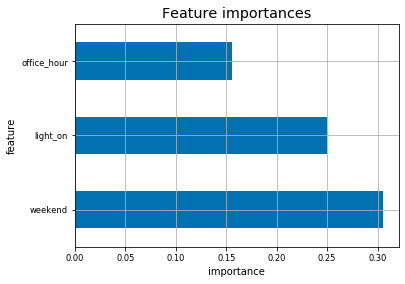

In [34]:
handpicked = MLPipe.run_pipeline(handpicked_pipe, handpicked_features, "rf_handpicked", save_model=False)